# Quickstart


`AutoEmulate`'s goal is to make it easy to create an emulator for your simulation. Here's the basic workflow:


In [1]:
from autoemulate.experimental.compare import AutoEmulate
from autoemulate.experimental.emulators import *

from autoemulate.experimental.simulations.projectile import Projectile

import warnings
warnings.filterwarnings("ignore")

## Toy simulation

Before we build an emulator with AutoEmulate, we need to get a set of input/output pairs from our simulation to use as training data.

Below is a toy simulation for a projectile's motion with drag (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). The simulation includes:
- Inputs: drag coefficient (log scale), velocity
- Outputs: distance the projectile travelled


In [2]:
projectile = Projectile()

# sample from a simulation
n_samples = 500
x = projectile.sample_inputs(n_samples).float()
y = projectile.forward_batch(x).float()

x.shape, y.shape

Running simulations: 100%|██████████| 500/500 [00:00<00:00, 1.23ksample/s]


(torch.Size([500, 2]), torch.Size([500, 1]))

## Comparing emulators

This is the core of `AutoEmulate`. With a set of inputs / outputs, we can run a full machine learning pipeline, including data processing, model fitting, model selection and hyperparameter optimisation in just a few lines of code. First, let's check the names of the available emulator models.


In [3]:
# Print list of available emulators
AutoEmulate.list_emulators()

,model_name,short_name
0,GaussianProcessExact,GPE
1,GaussianProcessExactCorrelated,GPEC
2,LightGBM,LGBM
3,SupportVectorMachine,SVM
4,RadialBasisFunctions,RBF
5,RandomForest,RF
6,MLP,MLP
7,EnsembleMLP,EMLP
8,EnsembleMLPDropout,EMLPD


Now let's initialise an `AutoEmulate` object.

This provides the simulation inputs and outputs, then fits a range of different models to the data, evaluating on witheld test data.

In [4]:
ae = AutoEmulate(x, y)

Comparing models: 100%|██████████| 9.00/9.00 [04:21<00:00, 29.1s/model]


Look at the summary for a comparison of emulator performace.

In [5]:
ae.summarise()

,model_name,x_transforms,y_transforms,rmse_score,r2_score
4,RadialBasisFunctions,[StandardizeTransform()],[StandardizeTransform()],5.741175e+04,9.990051e-01
0,GaussianProcessExact,[StandardizeTransform()],[StandardizeTransform()],1.195491e+05,9.979169e-01
2,LightGBM,[StandardizeTransform()],[StandardizeTransform()],8.448899e+05,9.845840e-01
1,GaussianProcessExactCorrelated,[StandardizeTransform()],[StandardizeTransform()],1.805766e+06,9.658113e-01
5,RandomForest,[StandardizeTransform()],[StandardizeTransform()],2.536424e+06,9.480234e-01
3,SupportVectorMachine,[StandardizeTransform()],[StandardizeTransform()],1.568406e+07,3.220264e-01
6,MLP,[StandardizeTransform()],[StandardizeTransform()],2.005747e+07,-1.969148e-01
7,EnsembleMLP,[StandardizeTransform()],[StandardizeTransform()],5.763426e+07,-9.005353e+06
8,EnsembleMLPDropout,[StandardizeTransform()],[StandardizeTransform()],5.768352e+07,-9.013050e+07


Choose an emulator based on the index from the summary dataframe, or quickly get the best result (based on `r2_score`).

In [11]:
best = ae.best_result()
print("Model ", best.id, " performed best: ", best.model_name)

Model  4  performed best:  RadialBasisFunctions


Plot the emulator predictions against the simulator outputs.

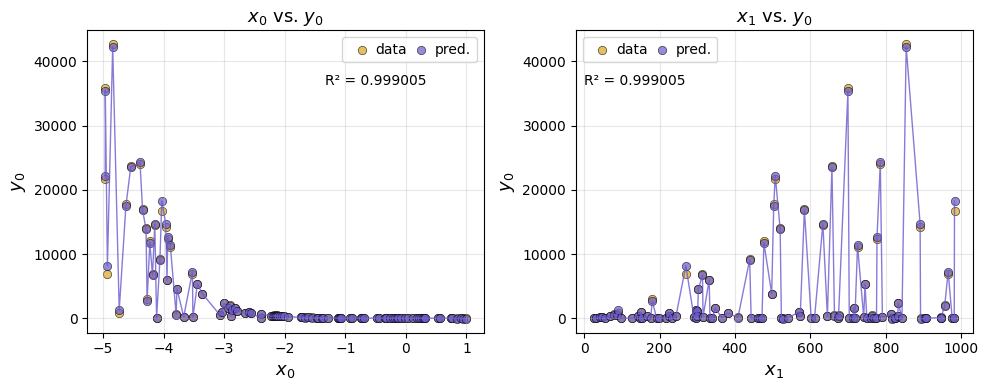

In [7]:
ae.plot(best.id)

## Predictions

We can use the model to make predictions for new inputs. Emulators in `AutoEmulate` can use the `predict` method to make predictions.


In [8]:
best.model.predict(x[:10])

tensor([[   9.8987],
        [2391.9756],
        [  34.4587],
        [   8.3037],
        [3544.9856],
        [2028.5695],
        [   5.5369],
        [ 155.7136],
        [  24.8643],
        [  -3.5776]])